# Calculating a Walkable Accessibility Score for Dublin in Python

Kevin Credit  
2024  

We will use Python to apply our knowledge of spatial accessibility on a dataset of urban points of interest (POI) in Dublin to create a 'Walkable Accessibility Score' (WAS).

This is done by computing the Euclidean distance between the centroids of Small Areas (demand units) for Dublin County and a pre-specified $k$ number of points of interest (POI) (supply sites) from the **open-source [Overture](https://github.com/cjber/overture-uk/tree/main) data**. These POIs are then down-weighted based on distance from the block group centroid according to a logistic distance decay function. In this notebook we will test a couple of different values for $k$ and the $upper$ distance decay parameter to find which combination best correlates with data from the Irish Census (2022) on commuting by foot at the Small Area scale. We then join the chosen values back to the Small Area polygons and map them to observe spatial patterns in walkable accesisbility.

### 1. Install and load necessary libraries

In [1]:
# The !pip command installs Python packages directly though the Jupyter notebook interface
# Note: the !pip commands can be commented out once the packages have been properly installed on a specific machine
# !pip install matplotlib

In [2]:
# !pip install scikit-learn

In [3]:
# !pip install pandas

In [4]:
# !pip install geopandas

In [5]:
# !pip install scipy

In [6]:
# !pip install numpy

In [7]:
# !pip install mapclassify

In [8]:
# !conda install contextily --channel conda-forge

In [9]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import contextily as cx

from sklearn.neighbors import BallTree
import geopandas as gpd

# This command specifies that plots should occur within the notebook rather than as an export
%matplotlib inline 

/Users/irenefarah/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


We must specify the correct directory path to load some packages. In the code below, REPLACE 'ifarah' with your personal username. It should be shown in the output directories of the installed packages above.

In [10]:
import sys  
sys.path.insert(1, '/users/ifarah/appdata/roaming/python/python39/site-packages')

### 2. Load data
Load the csv of POI data (with latitude and longitude coordinates) from the **tutorials** folder.

In [11]:
df = pd.read_csv('Dublin_POI.csv', sep=",", encoding='latin-1')

Check how large the dataset is and what information it contains.

In [12]:
"Your dataset contains " + str(len(df)) + " rows."

'Your dataset contains 41372 rows.'

In [13]:
sorted(list(df.columns.values.tolist()))

['addresses',
 'brand',
 'categories',
 'confidence',
 'emails',
 'fid',
 'id',
 'names',
 'phones',
 'socials',
 'sources',
 'updatetime',
 'version',
 'websites',
 'xcoord',
 'ycoord']

In [14]:
df.head() # This command shows the first 5 rows of a dataset

,fid,id,updatetime,version,names,categories,confidence,websites,socials,emails,phones,brand,addresses,sources,xcoord,ycoord
0,181,tmp_B926DB1847AB8100A2B644B14D8E0863,2023-07-24T00:00:00.000,0,"{""common"":[{""value"":""The Grooming Company"",""la...","{""main"":""pet_groomer"",""alternate"":[""pet_servic...",0.872156,"[""http://thegroomingco.ie/""]","[""https://www.facebook.com/191396621060975""]",NaN,"[""+353851694299""]","{""names"":null,""wikidata"":null}","[{""locality"":""Dublin"",""postcode"":""Dublin 15"",""...","[{""dataset"":""meta"",""property"":"""",""recordid"":""1...",-6.376240,53.386115
1,225,tmp_A140CB390F86D6971EFB1C4DB08F53F1,2023-07-24T00:00:00.000,0,"{""common"":[{""value"":""Mount Martin Surgery"",""la...","{""main"":""hospital"",""alternate"":null}",0.734331,NaN,"[""https://www.facebook.com/366765130614749""]",NaN,"[""+35316244549""]","{""names"":null,""wikidata"":null}","[{""locality"":""Naas"",""postcode"":""W23 P8P3"",""fre...","[{""dataset"":""meta"",""property"":"""",""recordid"":""3...",-6.495517,53.365849
2,229,tmp_DBCB2BC9DE1641B5EAC4B9C72640C79D,2023-07-24T00:00:00.000,0,"{""common"":[{""value"":""Excel Fitness Studios"",""l...","{""main"":""gym"",""alternate"":[""active_life"",""spas""]}",0.386823,"[""https://legitfit.com/authenticate/signup/exc...","[""https://www.facebook.com/1414286868859864""]",NaN,NaN,"{""names"":null,""wikidata"":null}","[{""locality"":""Dublin"",""postcode"":""D16 E527"",""f...","[{""dataset"":""meta"",""property"":"""",""recordid"":""1...",-6.236680,53.305640
3,305,tmp_BFB9FA85099D3C68B47DA6467A0FF081,2023-07-24T00:00:00.000,0,"{""common"":[{""value"":""Paddy Power"",""language"":""...","{""main"":null,""alternate"":null}",0.600000,NaN,NaN,NaN,NaN,"{""names"":null,""wikidata"":null}","[{""locality"":""Stillorgan"",""postcode"":""A94 XR90...","[{""dataset"":""msft"",""property"":"""",""recordid"":""1...",-6.184709,53.289711
4,341,tmp_CA7B3077FE4BDAD32E58D8FC87865CF1,2023-07-24T00:00:00.000,0,"{""common"":[{""value"":""Dublin Ferry Port"",""langu...","{""main"":""travel"",""alternate"":null}",0.687736,NaN,"[""https://www.facebook.com/238318102895315""]",NaN,NaN,"{""names"":null,""wikidata"":null}","[{""locality"":""Dublin"",""country"":""IE""}]","[{""dataset"":""meta"",""property"":"""",""recordid"":""2...",-6.198494,53.346520


Create a GeoDataFrame (which is a spatial data type for use within Python) from the  latitude and longitude coordinates within the `Dublin_POI` csv.

In [15]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.xcoord, df.ycoord),
    crs='epsg:4326') # epsg specifies the projection

# Change the Coordinate Reference System (CRS)
# Check for different projections here: https://epsg.io/
gdf = gdf.to_crs('epsg:2157')

Check that the CRS actually changed.

In [16]:
gdf.crs

<Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Make sure that the geometry for each row has a value.

In [17]:
gdf = gdf[~gdf.is_empty]

In [18]:
"Your dataset contains " + str(len(gdf)) + " rows."

'Your dataset contains 41372 rows.'

Add an `ID` column to the GeoDataFrame and create a new GeoDataFrame that contains only the `ID` and `geometry` columns (`am_id`).

In [19]:
gdf["ID"] = gdf.index

am_id = gdf[['geometry']]
am_id.head(3)

,geometry
0,POINT (708016.090 738556.209)
1,POINT (700129.609 736127.461)
2,POINT (717520.263 729823.035)


Load the Small Area shapefile for the demand units from the **tutorials** folder. We will then change the Coordinate Reference System (CRS) to Irish Transverse Mercator to match the POI file and add a new `ID` column.

In [20]:
s_v = gpd.read_file('dublin_county/DublinCounty_SA.shp') # Load geography (oftentimes as shapefile).

s_v = s_v.set_crs('epsg:2157', allow_override=True) # Set the Coordinate Reference System
s_v.rename(columns={'SA_PUB2022': 'ID'}, inplace=True) # Rename the columns for convenience

Now we will extract the centroids of the polygons, which we will use to calculate distance to the $k-$ nearest POIs, and replace the `geometry` column in the `s_v` GeoDataFrame with the centroids of each Small Area. This effectively transforms the polygon GeoDataFrame to a points file.

In [21]:
s_v['geometry'] = s_v.centroid

# Check that the geometry is indeed in point form
s_v[['geometry']].head(3)

,geometry
0,POINT (713537.660 729730.707)
1,POINT (713444.193 730237.469)
2,POINT (714104.795 730151.481)


### 3. Build the functions for calculating the access score

Now we'll create the necessary functions for calculating the access score itself. This next cell creates a function called `get_nearest_neighbors` that takes as input a source GeoDataFrame (origins) and a candidates GeoDataFrame (destination) and a specified $k$ number of nearest neighbours. The function then calculates Euclidean distance from each source to each of the $k-$ nearest neighbours using the `BallTree` function from the `scikit-learn` library.

In [22]:
# This cell is creating a function for eastimating nearest neighbors from point to point.
def get_nearest_neighbors(gdf1, gdf2, k_neighbors=2):
    '''Find k nearest neighbors for all source points from a set of candidate points
    modified from: https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html    
    Parameters
    ----------
    gdf1 : geopandas.DataFrame
    Geometries to search from.
    gdf2 : geopandas.DataFrame
    Geoemtries to be searched.
    k_neighbors : int, optional
    Number of nearest neighbors. The default is 2.
    Returns
    -------
    gdf_final : geopandas.DataFrame
    gdf1 with distance, index and all other columns from gdf2.'''

    src_points = [(x,y) for x,y in zip(gdf1.geometry.x , gdf1.geometry.y)]
    candidates =  [(x,y) for x,y in zip(gdf2.geometry.x , gdf2.geometry.y)]

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    closest_gdfs = []
    for k in np.arange(k_neighbors):
        gdf_new = gdf2.iloc[indices[k]].reset_index()
        gdf_new['distance'] =  distances[k]
        gdf_new = gdf_new.add_suffix(f'_{k+1}')
        closest_gdfs.append(gdf_new)
    
    closest_gdfs.insert(0,gdf1)    
    gdf_final = pd.concat(closest_gdfs,axis=1)

    return gdf_final

Next, the function `clean_dataframe` reshapes the output from `get_nearest_neighbors` from 'wide' to 'long' format and renames some of the columns in a consistent way. This is necessary to simplify the calculation of the distance decay function - in essence, `get_nearest_neighbors` outputs a DataFrame where each row corresponds to an origin point, and each of the $k$ destinations are marked as separate columns - each with its own corresponding column for `distance`, `index` (ID), and its own `geometry`. This is 'wide' format and means that for $k=10$ nearest-neighbours, 30 additional columns will be added to the DataFrame (and 150 for $k=50$, etc.). In 'long' format, the data structure is simplified by adding a row for each *destination* (thus increasing the number of rows) which allows us to maintain only one column for `origin` (index of the origin), `dest` (index of the destination), `euclidean` (distance between the two), and `neighbor` (what rank $k$ it is).

In [23]:
def clean_dataframe(df):
    # Create the ID2 column
    df["ID2"] = df.index

    # Reshape the dataframe from wide to long format using the provided suffix
    long_df = pd.wide_to_long(df, stubnames=["distance_", "index_", "geometry_"], i="ID2", j="neighbor")

    # Rename columns
    long_df.loc[:, 'origin'] = long_df['ID']
    long_df.loc[:, 'dest'] = long_df['index_']
    long_df.loc[:, 'euclidean'] = long_df['distance_']

    # Reset index and keep necessary columns
    long_df = long_df.reset_index(level="neighbor")
    cost_df = long_df[['euclidean', 'origin', 'dest', 'neighbor']]

    # Sort the dataframe by origin and euclidean distance
    cost_df.sort_values(by=['origin', 'euclidean'], inplace=True)

    return cost_df

The last function `acces_measure` calculates the distance decay weights for each destination based on the long-format DataFrame. It starts by converting the Euclidean distance into a travel time (based on a flat assumption of 5 kph walking speed), and then applies a logistic distance decay function to calculate the value `LogitT_5`. The function takes two primary inputs: `upper` determines the 'intercept' (i.e., minimum and maximum threhsolds) of the function, which larger values corresponding to larger thresholds, and `decay` determines the slope of the function.

In [24]:
def access_measure(df_cost, df_sv, upper, decay):
    # Calculate time from euclidean distance
    # https://journals-sagepub-com.may.idm.oclc.org/doi/10.1177/0265813516641685
    df_cost['time'] = (df_cost['euclidean'] * 3600) / 5000  # convert distance into time (rate of 5kph)
    
    # Calculate LogitT_5 using the provided formula
    df_cost['LogitT_5'] = 1 - (1 / (np.exp((upper / 180) - decay * df_cost['time']) + 1))
    
    # Sum weighted distances by tract (origin) ID
    cost_sum = df_cost.groupby("origin").sum()
    cost_sum['ID'] = cost_sum.index
    
    # Merge with the corresponding smaller sv original dataframe
    cost_merge = df_sv.merge(cost_sum, how='inner', on='ID')
    
    return cost_merge

### 4. Run the `get_nearest_neighbors` function for $k = $ 10, 50, and 150 nearest neighbors and clean the data

In this practical we will test a couple of different parameters against the 2022 Irish Census data for % of people commuting to work by walking to see which combination of $k$ and `upper` best matches the observed data. First, we have to calculate three sets of nearest neighbors.

In [25]:
#For 10 NN
closest10 = get_nearest_neighbors(s_v, am_id, k_neighbors=10)
#For 50 NN
closest50 = get_nearest_neighbors(s_v, am_id, k_neighbors=50)
#For 150 NN
closest150 = get_nearest_neighbors(s_v, am_id, k_neighbors=150)

Then we will clean the dataframes by converting them from wide to long format. This bit of code takes the longest to run in the notebook.

In [26]:
cost10 = clean_dataframe(closest10)
cost50 = clean_dataframe(closest50)
cost150 = clean_dataframe(closest150)

/var/folders/93/2tplx4tn2jdc1zgf9bm7hmfr0000gn/T/ipykernel_67586/433994779.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_df.sort_values(by=['origin', 'euclidean'], inplace=True)
/Users/irenefarah/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/var/folders/93/2tplx4tn2jdc1zgf9bm7hmfr0000gn/T/ipykernel_67586/433994779.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

### 5. Estimate the access metric using the logistic decay function

Now we are ready to calculate the access score based on the three different values of $k$ (10, 50, 150) and three different values for `upper` (200, 400, 800). In this case we will hold `decay` constant (0.008), but this could also be tweaked if desired. We start by calculating the % of people comuting by foot from the Census data embedded in the `s_v` DataFrame, which simplifies the comparisons later on. 

In [27]:
#Calculate Foot commuting %
s_v['Foot'] = s_v.T11_1_FT/s_v.T11_1_TT

In [28]:
result10_200 = access_measure(cost10, s_v, upper=200, decay=.008)
result50_200 = access_measure(cost50, s_v, upper=200, decay=.008)
result150_200 = access_measure(cost150, s_v, upper=200, decay=.008)

result10_400 = access_measure(cost10, s_v, upper=400, decay=.008)
result50_400 = access_measure(cost50, s_v, upper=400, decay=.008)
result150_400 = access_measure(cost150, s_v, upper=400, decay=.008)

result10_800 = access_measure(cost10, s_v, upper=800, decay=.008)
result50_800 = access_measure(cost50, s_v, upper=800, decay=.008)
result150_800 = access_measure(cost150, s_v, upper=800, decay=.008)

### 6. Calculate the correlation betweeen foot commuting % and the Walkable Accessibility Scores

We now have access score results for 9 different combinations of $k$ and `upper` - to determine which we should use as our 'final' result, we will run simple Pearson correlations with the % of people comuting by foot and choose the combination with the highest correlation. While the concept of the WAS is meant to encompass destination accessibility in a way that is wider than simply commuting to work, this does provide a useful point of comparison for selecting the best-fitting paraemeter combinations.

In [29]:
stats.pearsonr(result10_200['LogitT_5'],result10_200['Foot'])

PearsonRResult(statistic=0.4522477731988813, pvalue=1.9003458064857914e-254)

In [30]:
stats.pearsonr(result50_200['LogitT_5'],result50_200['Foot'])

PearsonRResult(statistic=0.5223341546150109, pvalue=0.0)

In [31]:
stats.pearsonr(result150_200['LogitT_5'],result150_200['Foot'])

PearsonRResult(statistic=0.5512809430544916, pvalue=0.0)

In [32]:
stats.pearsonr(result10_400['LogitT_5'],result10_400['Foot'])

PearsonRResult(statistic=0.4131421317749126, pvalue=1.6682652730880423e-208)

In [33]:
stats.pearsonr(result50_400['LogitT_5'],result50_400['Foot'])

PearsonRResult(statistic=0.507403927025637, pvalue=0.0)

In [34]:
stats.pearsonr(result150_400['LogitT_5'],result150_400['Foot'])

PearsonRResult(statistic=0.5577587489924234, pvalue=0.0)

In [35]:
stats.pearsonr(result10_800['LogitT_5'],result10_800['Foot'])

PearsonRResult(statistic=0.2647688673195545, pvalue=3.507391759272934e-82)

In [36]:
stats.pearsonr(result50_800['LogitT_5'],result50_800['Foot'])

PearsonRResult(statistic=0.395977022858196, pvalue=3.4666710505928083e-190)

In [37]:
stats.pearsonr(result150_800['LogitT_5'],result150_800['Foot'])

PearsonRResult(statistic=0.49581904906476093, pvalue=3.04518035925e-313)

### 7. Mapping the results

We'll start by mapping all of the Small Area centroids (in blue) and POIs (in orange) so that we can get a general sense for the overall spatial layout of the data. This is easily done by using the `matplotlib` command `plot` specifying a particular figure size. When a second plot is called in the same cell, it simply plots on top of the initial plot. For the second set of points, we also specify the marker size and colour.

<Axes: >

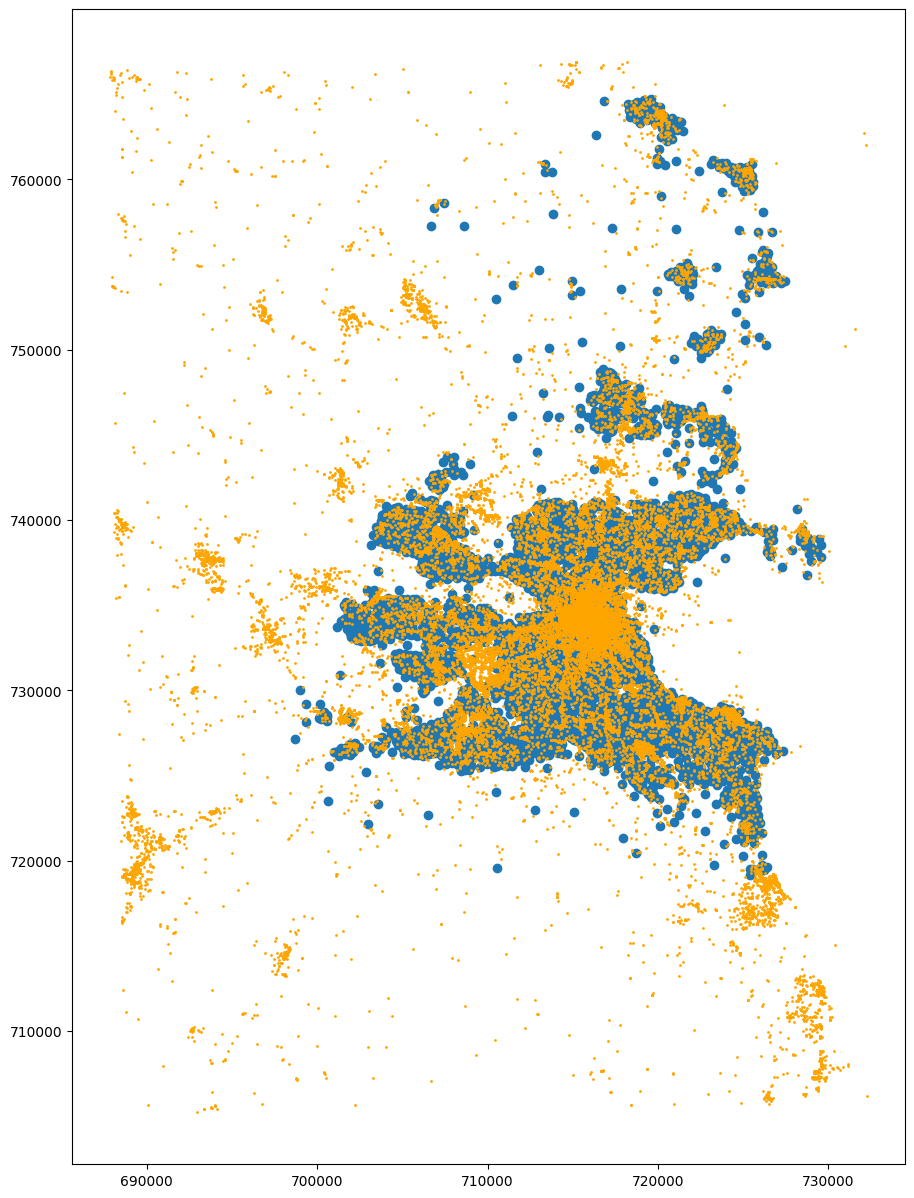

In [38]:
#Plot SAs and POIs (in orange) 
base = s_v.plot(figsize=(15,15))
am_id.plot(ax=base, color='orange', markersize = 1, figsize=(15,15))

Now, let's map the final results. Our comparative analysis above indicates that $k=150$ and `upper` = 400 provide the highest correlation with observed walking commute data from the Census (0.558). We will choose that DataFrame (`result150_400`) and merge it with the polygon Small Area GeoDataFrame so that we can map it.

In [39]:
s_v2 = gpd.read_file('dublin_county/DublinCounty_SA.shp') # Re-load polygon geography
s_v2 = s_v2.set_crs('epsg:2157', allow_override=True) # Set the Coordinate Reference System
s_v2.rename(columns={'SA_PUB2022': 'ID'}, inplace=True) # Rename the columns for convenience
result150_400 = result150_400[['ID', 'LogitT_5']]
s_v2 = s_v2.merge(result150_400, how='inner', on='ID') # Inner join

This final bit of code specifies how to plot a choropleth map in `matplotlib`. First, we specify that we will draw multiple plots (i.e., the legend, title, etc.) in one figure. Then we use the `to_crs` command to set the Coordinate Reference System and `plot` to draw in the choropleth data. You can see how we specified the 'viridis' [colour ramp](https://matplotlib.org/stable/users/explain/colors/colormaps.html) for `cmap`, white polygon boundaries, and a transparency value (`alpha`) of 0.68. We also removed the coordinate axes from the plot, add a title, and *can* add a [basemap](https://contextily.readthedocs.io/en/latest/intro_guide.html) (from Carto, a basemap called [Voyager](https://carto.com/blog/new-voyager-basemap)) by removing the comment `#` from the last line of code (and commenting out the line above, `# plt.show()`. However, due to the difficult installation setup in the lab, for this exercise we have not installed the required `contextily` package. 

**Note:** We could also set a particular classification scheme (e.g., equal interval) and the number of classification breaks if we had installed the `mapclassify` package by adding these items to a line of code like this: `s_v2.to_crs('EPSG:3857').plot(ax=ax, column='LogitT_5', legend=True, cmap='viridis', edgecolor='white', scheme='equalinterval', k=10, alpha=.68)`. However, installing `mapclassify` requires an older verison of `numpy` that may cause trouble for other package dependencies, so we will skip that here.

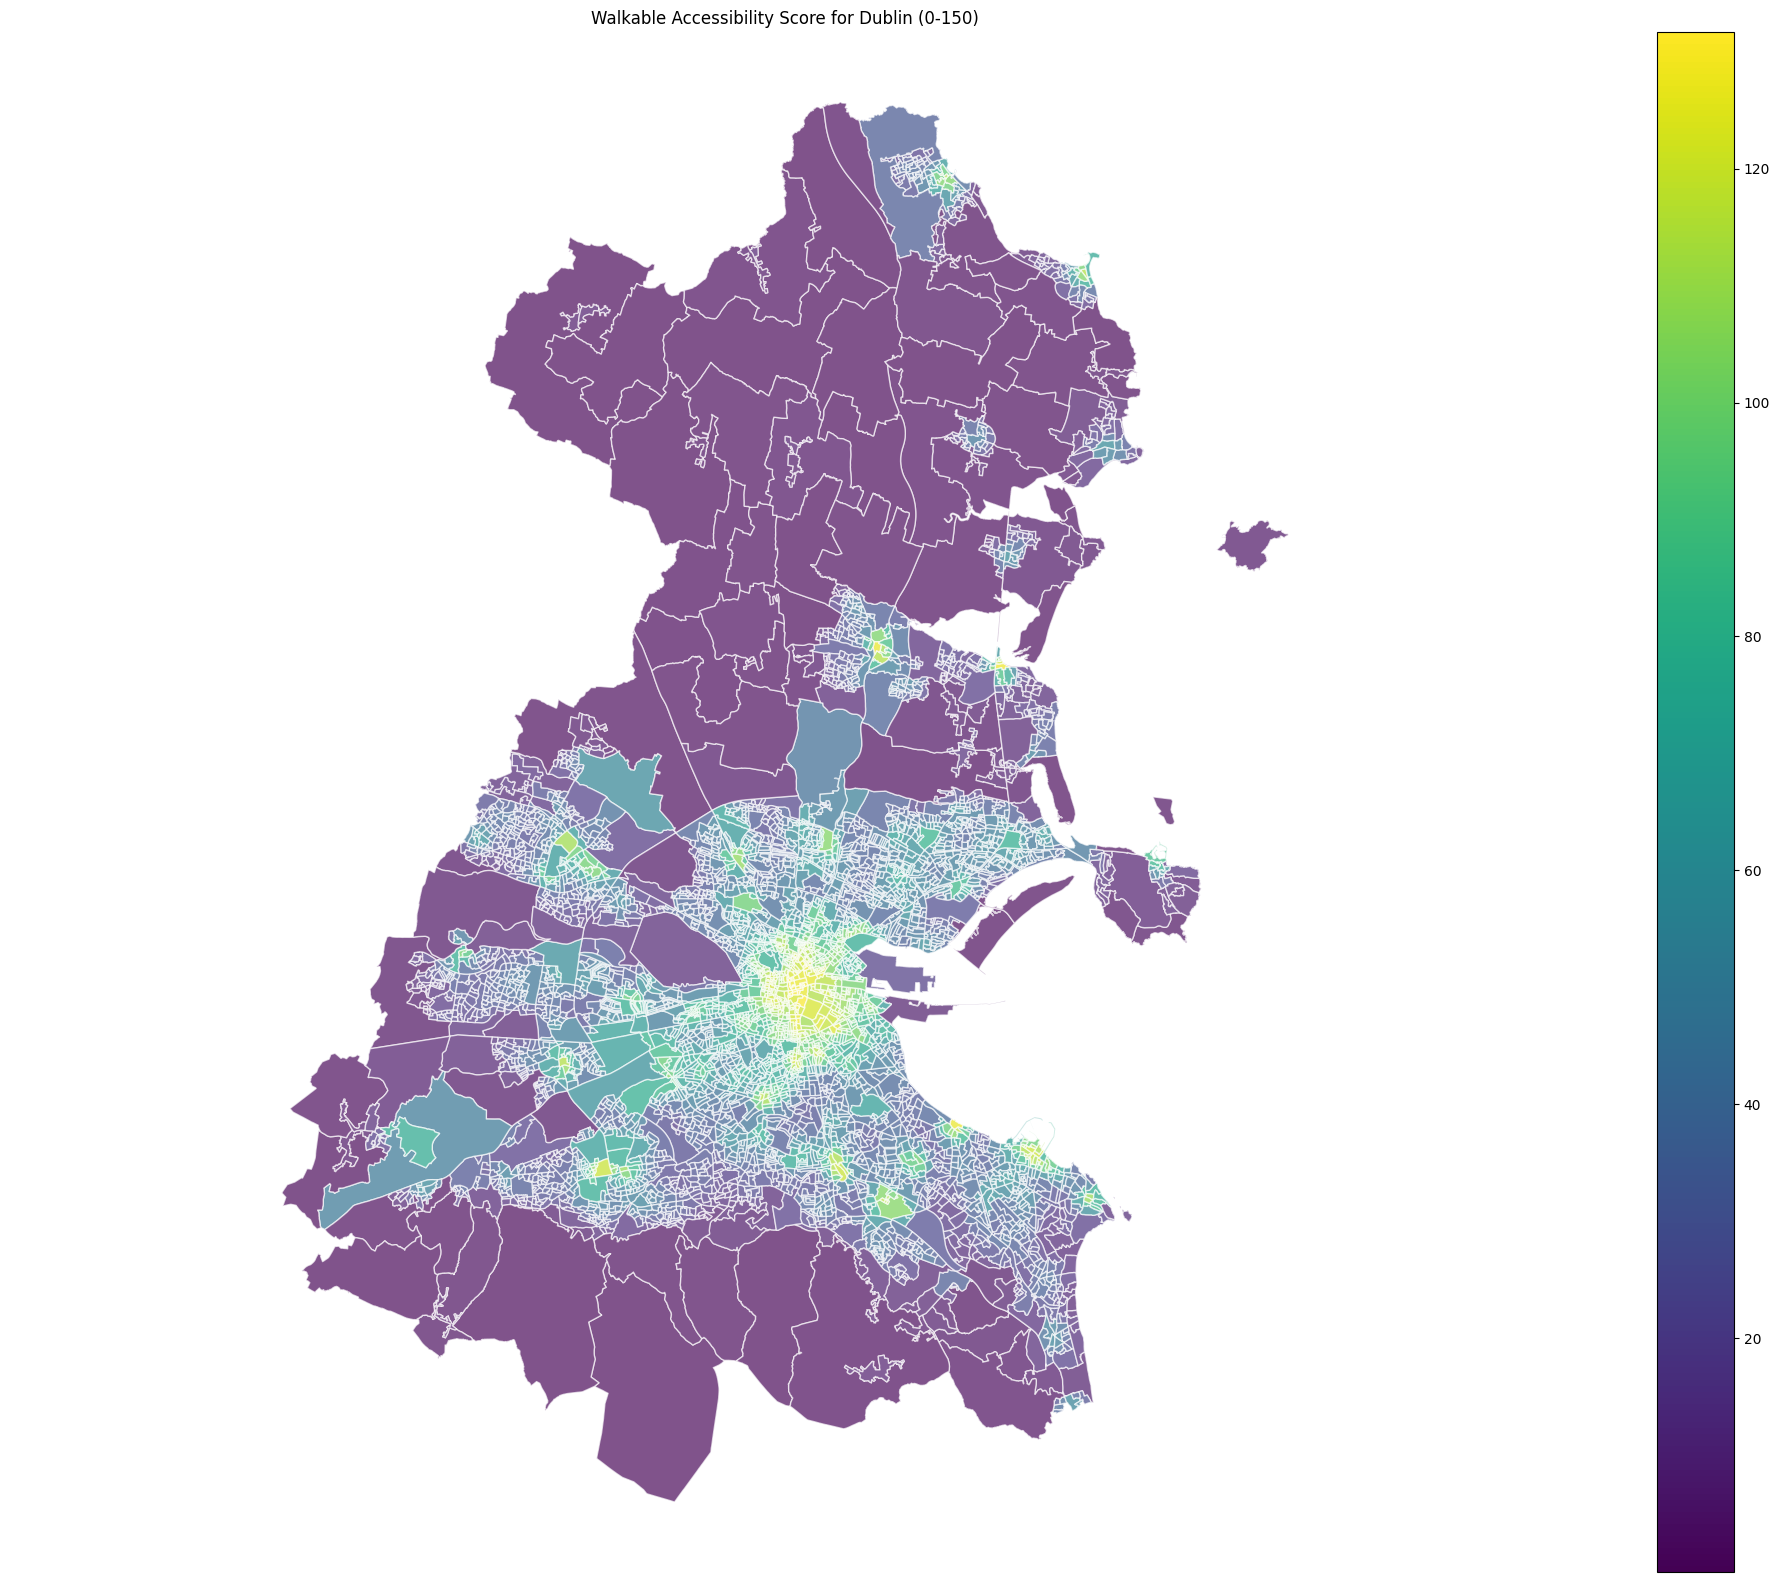

In [40]:
f, ax = plt.subplots(1, figsize=(25, 20)) #Subplots allows you to draw multiple plots in one figure
s_v2.to_crs('EPSG:3857').plot(ax=ax, column='LogitT_5', legend=True, cmap='viridis', edgecolor='white', alpha=.68)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('Walkable Accessibility Score for Dublin (0-150)') #Plot title text
plt.axis('equal') #Set x and y axes to be equal size
plt.show()
# cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

Finally, we can also export the data as a csv to join to the Small Area shapefile in other GIS software.

In [42]:
#Export as a csv
result150_400.to_csv('dublin_result150_400.csv')